# Example Workflow for CM2.6

- Interpolate atmosphere onto ocean
- Recalculate flux terms from ocean res (`full_res_*`)
- Coarsen the recalculated flux + flux input fields
- Recompute flux terms once again from coarsened input fields (`coarse_res_*`)
- Look at the difference (`full_res_* - coarse_res_*`)

In [1]:
# !mamba install aerobulk-python -y

In [2]:
from aerobulk import skin, noskin
import fsspec
import xarray as xr
import numpy as np
import xesmf as xe
import os
from intake import open_catalog
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_ocean  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs)
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)


# instead do this
ds_atmos = ds_atmos.chunk({'time':1})

In [4]:
import json
import gcsfs

# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
path = 'ocean-transport-group/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr'
mapper = fs.get_mapper(path)
ds_regridder = xr.open_zarr(mapper).load()
regridder = xe.Regridder(
    ds_atmos.olr.to_dataset(name='dummy').isel(time=0),
    ds_ocean.surface_temp.to_dataset(name='dummy').isel(time=0),
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x576_2700x3600_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 576) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

In [5]:
import subprocess
import logging
from distributed import WorkerPlugin
from dask_gateway import Gateway

class MambaPlugin(WorkerPlugin):
    """
    Install packages on a worker as it starts up.

    Parameters
    ----------
    packages : List[str]
        A list of packages to install with pip on startup.
    """
    def __init__(self, packages):
        self.packages = packages

    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['mamba', 'install'] + self.packages + ['-y'])
        logger.info("Installed %s", self.packages)
        
gateway = Gateway()

# stop all existing clusters
print(gateway.list_clusters())
for c in gateway.list_clusters():
    cluster = gateway.connect(c.name)
    cluster.shutdown()

options = gateway.cluster_options()
options.worker_cores = 4
options.worker_memory = 48

cluster = gateway.new_cluster(options, shutdown_on_close=True)
client = cluster.get_client()

plugin = MambaPlugin(['aerobulk-python'])
client.register_worker_plugin(plugin)
cluster.scale(3)

[ClusterReport<name=prod.d44b64ded8dd4194a24b4a5e472f0946, status=RUNNING>]


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.a45a84c9ff8240ef96ad4b4e069cb496/status,


In [7]:
# cluster

### Distributed Notes
This is utterly bizarre. No matter what size of problem I choose, it works fine until the last couple of tasks. It just gets stuck. During the progress there is some stuff going on that seems fishy: Tasks

In [8]:
# from multiprocessing.pool import ThreadPool
# import dask
# dask.config.set(pool=ThreadPool(16))

In [9]:
def noskin_ds_wrapper(ds_in, **kwargs):
    ds_out = xr.Dataset()
    ds_in = ds_in.copy(deep=False)
    
    sst = ds_in.surface_temp + 273.15
    t_zt = ds_in.t_ref
    hum_zt = ds_in.q_ref
    u_zu = ds_in.u_ref
    v_zu = ds_in.v_ref
    slp = ds_in.slp * 100 # check this
    zu = 10
    zt = 2
    
    ql, qh, taux, tauy, evap =  noskin(
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp=slp,
        algo='ecmwf',
        zt=2,
        zu=10,
        **kwargs
    )
    ds_out['ql'] = ql
    ds_out['qh'] = qh
    ds_out['evap'] = evap
    ds_out['taux'] = taux 
    ds_out['tauy'] = tauy
    return ds_out

## Old approach (complex dask graph)

In [10]:
ds_atmos_regridded = regridder(ds_atmos[['slp', 'v_ref', 'u_ref', 't_ref', 'q_ref']])# We are only doing noskin for now , 'swdn_sfc', 'lwdn_sfc'
ds_atmos_regridded

## combine into merged dataset
ds_merged = xr.merge(
    [
        ds_atmos_regridded,
        ds_ocean[['surface_temp']],
    ]
)
ds_merged = ds_merged.transpose(
    'xt_ocean', 'yt_ocean', 'time'
)

In [11]:
ds_merged

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Data variables:
    slp           (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    v_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    u_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    t_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    q_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    surface_temp  (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [12]:
ds_out = noskin_ds_wrapper(ds_merged, input_range_check=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


In [11]:
# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)

In [13]:
subfolder = 'ocean-transport-group/scale-aware-air-sea/outputs/temp/'
path = f'{subfolder}CM26_high_res_output_debug.zarr'
mapper = fs.get_mapper(path)

In [14]:
# delete the mapper
flist = fs.rm(path, recursive=True)

FileNotFoundError: ['ocean-transport-group/scale-aware-air-sea/outputs/temp/CM26_high_res_output_debug.zarr']

In [ ]:
# Ad-hoc hack (splitting the dataset into batches and append to zarr store

from dask.diagnostics import ProgressBar
interval = 10
nt = len(ds_merged.time)
splits = list(range(0,nt,interval))
if splits[-1] != nt:
    splits = splits + [nt]
# for ii in tqdm(range(len(splits)-1)):
# Just for testing:
for ii in tqdm(range(3)):
    start = splits[ii]
    stop = splits[ii+1]
    print(ii)
    ds_write = ds_out.isel(time=slice(start, stop))
    print(ds_write.time[0].data)
    print(ds_write.time[-1].data)
    with ProgressBar():
        if start == 0:
            ds_write.to_zarr(mapper, consolidated=True)
        else:
            ds_write.to_zarr(mapper, append_dim='time', consolidated=True)
        # ds_write.to_zarr(mapper, region={'time':slice(start, stop)}, consolidated=True)
    # TODO: Should I consolidate this after appending?

  0%|          | 0/3 [00:00<?, ?it/s]

0
0181-01-01 12:00:00
0181-01-10 12:00:00


2022-08-01 22:32:28,987 - distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('store-map-6da18ec03f03f52ebe3f67baa203f87b', 0, 0, 6)": (), "('store-map-d81b96637530bbc4115381ae5e40a292', 0, 0, 6)": ()}


1
0181-01-11 12:00:00
0181-01-20 12:00:00


This just gets stuck. Nothing happens on the dask end for the last remaining tasks...
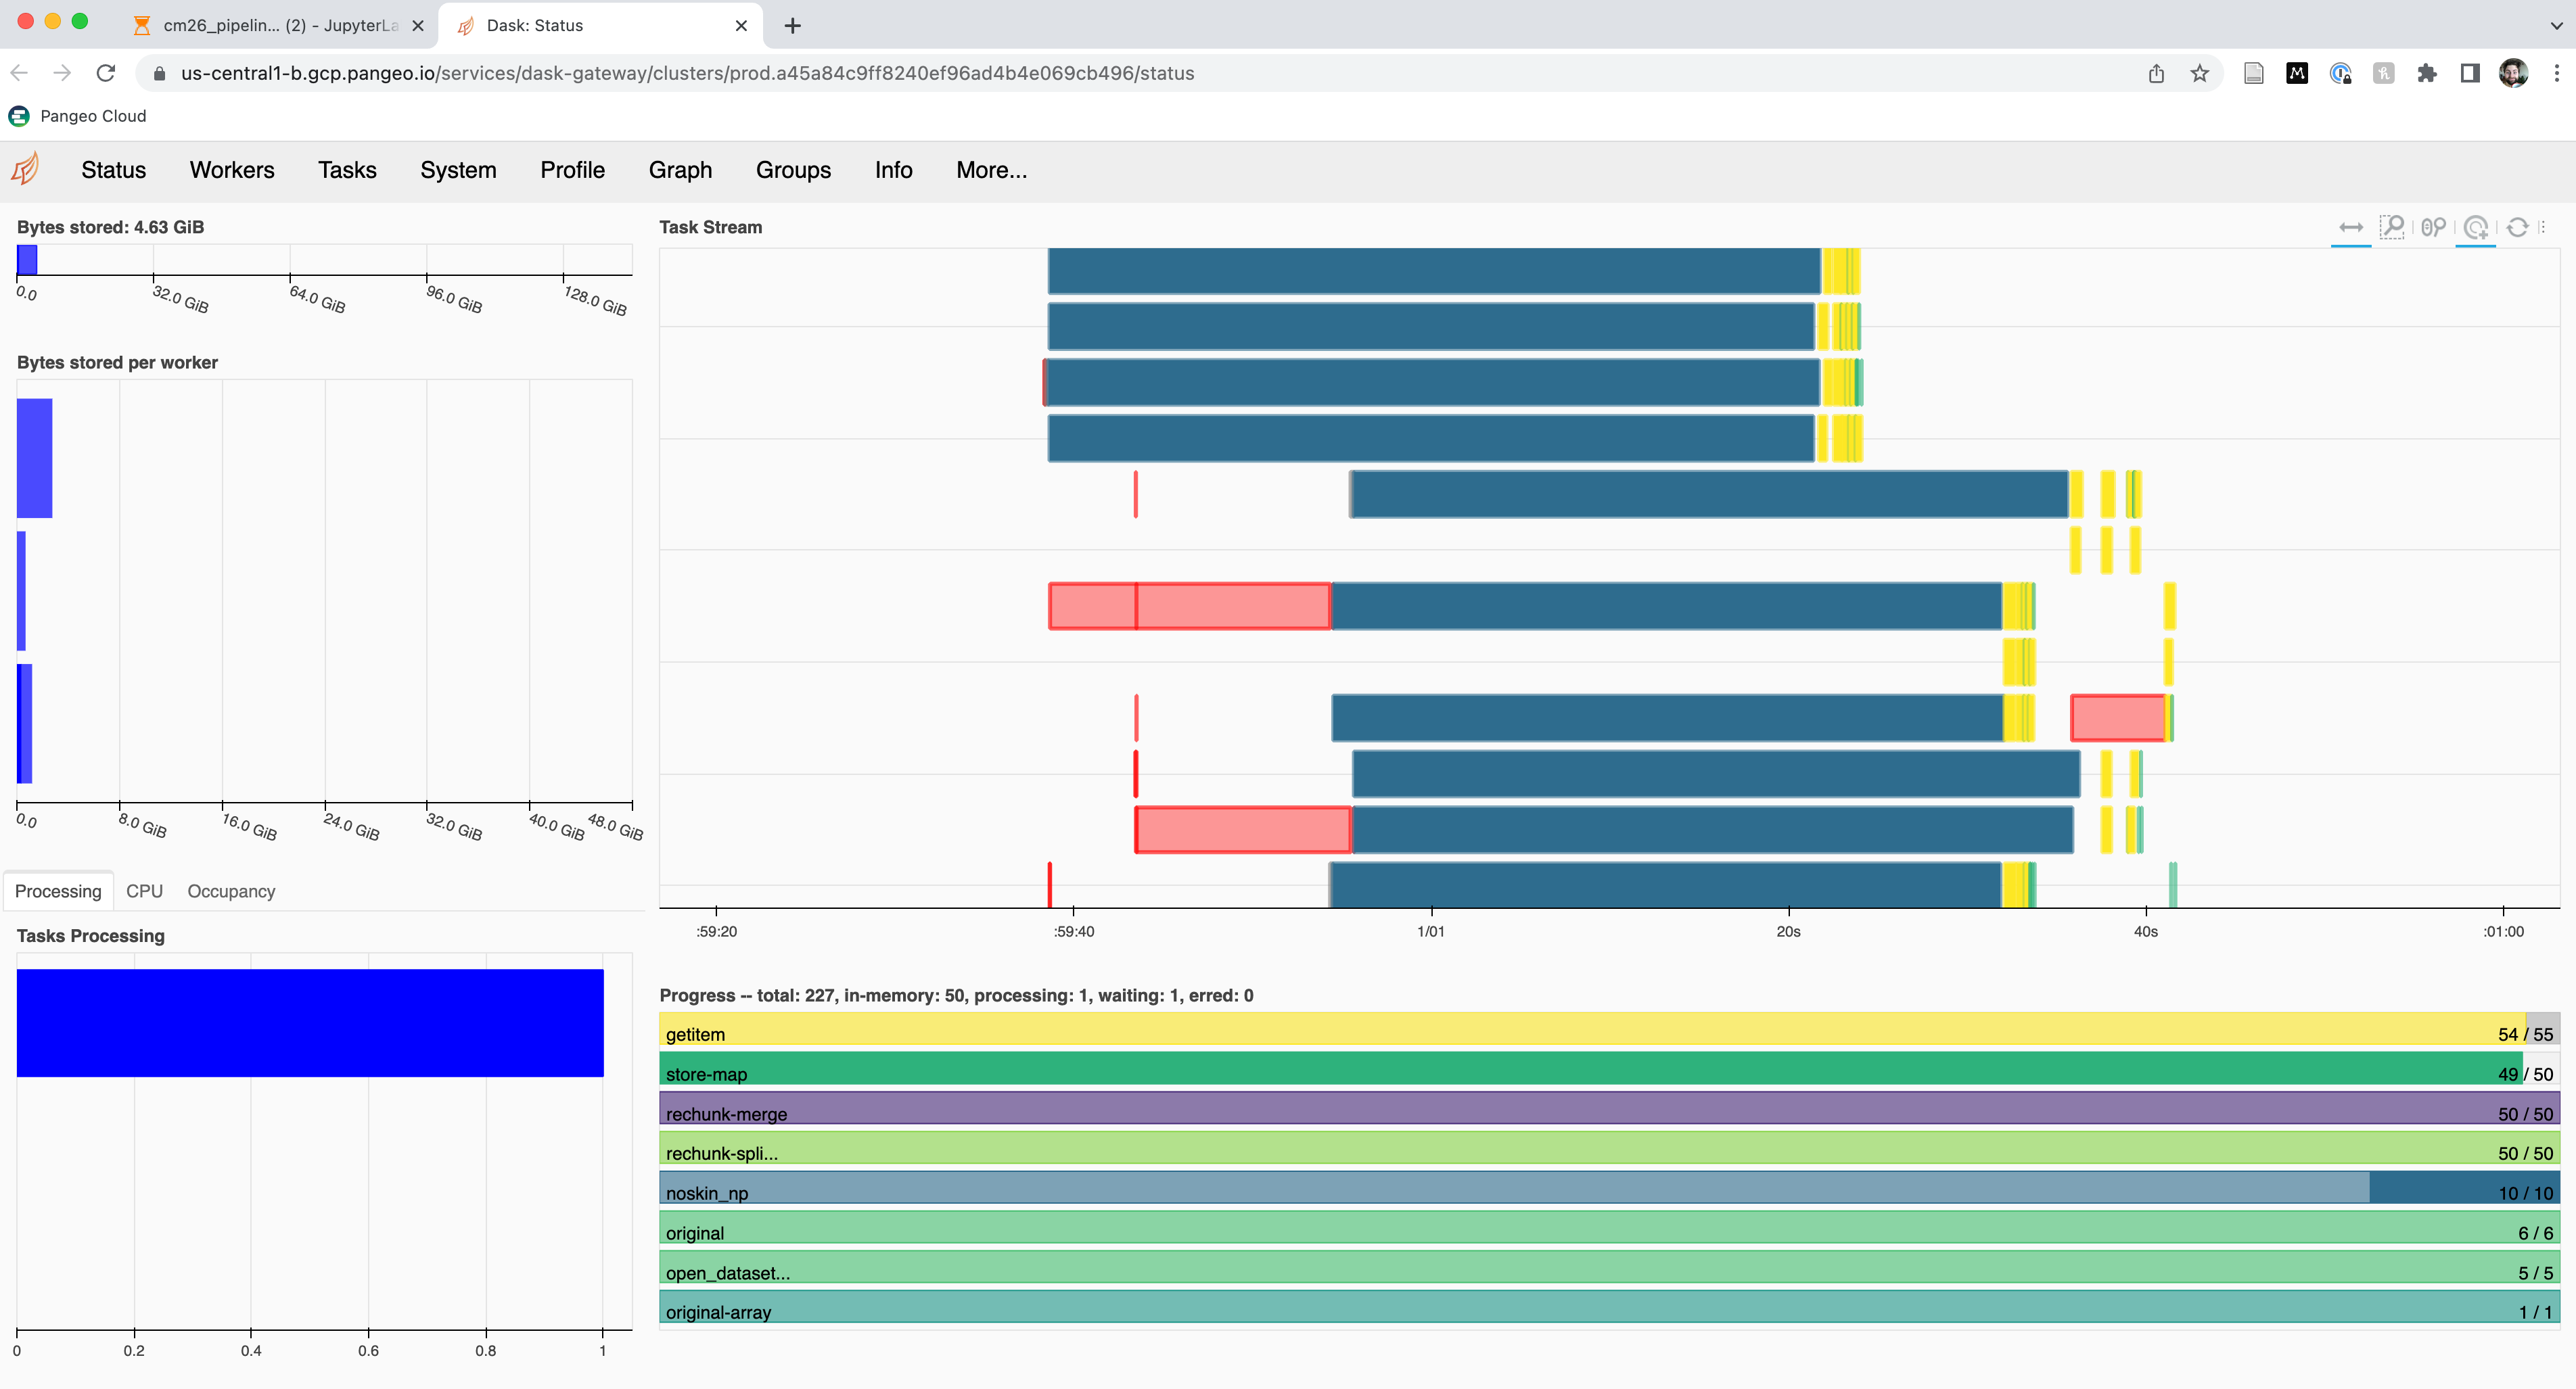

### Cluster notes
This seems to work fine if each worker has ~12 GB, for smaller ones thsi produces all kind of warnings, and dying workers

In [11]:
# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)

subfolder = 'ocean-transport-group/scale-aware-air-sea/outputs/temp/'
mapper = fs.get_mapper(f'{subfolder}CM26_high_res_output.zarr')
# fs.rm(mapper.root, recursive=True)

In [12]:
for f in fs.ls(subfolder):
    fs.rm(f, recursive=True)

In [13]:
# build a dask graph
results = []
for ti in range(360):
    single_mapper = fs.get_mapper(f'{subfolder}CM26_high_res_output_{ti}.zarr') # TODO: 
    results.append(delayed(full_wrapper)(ds_atmos.isel(time=ti), ds_ocean.isel(time=ti), regridder, single_mapper, ti))

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    sum(results).compute()

[#######################                 ] | 58% Completed | 24min 48.5s

If this works I need to figure out how to write to regions.

## The coarsening etc

In [30]:
# add area 
ds = ds.assign_coords(area=ds_oc_grid.area_t)#.load()

### Manually do a weighted coarsen
> Would be nice if this could work with the xr.weighted logic!

In [31]:
# # which fields contain nans?
# for n,da in ds.items():
#     print(n, np.isnan(da.isel(time=0)).any().load().data)

In [32]:
coarsen_win = dict(xt_ocean=20, yt_ocean=20)
mean_dims = ['xt_ocean', 'yt_ocean']

masked_area = ds.area.where(~np.isnan(ds.surface_temp.isel(time=0)))
ds_weighted = ds * masked_area
ds_coarsened = ds_weighted.coarsen(**coarsen_win).sum(mean_dims) / masked_area.coarsen(**coarsen_win).sum(mean_dims)


# Apply a new (strict) landmask to fields that had nans in them before
coarsened_landmask = coarsened_landmask = np.isnan(ds['surface_temp'].isel(time=0)).coarsen(**coarsen_win).sum(mean_dims)>0
for var in ['qh', 'ql', 'surface_temp', 't_ref', 'slp']:
    ds_coarsened[var] = ds_coarsened[var].where(~coarsened_landmask)
    
# # t_ref is weird. It has 0 values to begin with
# ds_coarsened['t_ref'] = ds_coarsened['t_ref'].fillna(275.0) #TODO: check if we can fill with 0
# ds_coarsened['slp'] = ds_coarsened['slp'].fillna(100000/100)

# # # ad hoc filling of values
# for va, fillval in [('q_ref', 0), ('u_ref', 0), ('v_ref', 0), ('slp', 100000/100), ('t_ref',275.0)]:
#     ds_coarsened[va] = ds_coarsened[va].fillna(fillval)

In [33]:
ds_coarsened = ds_coarsened.isel(time=slice(0,120))
ds_coarsened.nbytes/1e9

0.0653214

In [34]:
ds_coarsened = ds_coarsened.load()

KeyboardInterrupt: 

In [ ]:
ds_coarsened

In [ ]:
ds_coarsened['qh'].mean('time').plot(x='xt_ocean', vmax=100)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()
2022-06-23 18:24:00,812 - distributed.client - ERROR - Exception raised while shutting down cluster prod.5ef01b5b9d4e4e7ab704b625f1f9c5ec
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 993, in _stop_internal
    await self.gateway._stop_cluster(self.name)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 654, in _stop_cluster
    await self._request("DELETE", url)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 397, in _request
    resp = await session.request(method, url, json=json, **self._request_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/aiohttp/client.py", line 535, in _request
    conn = await self._connector.connect(
  F

## implement a range check

We might want to implement this as an option on the nb/xarray wrapper?

In [ ]:
sst = ds_coarsened.surface_temp + 273.15
t_zt = ds_coarsened.t_ref
hum_zt = ds_coarsened.q_ref
u_zu = ds_coarsened.u_ref
v_zu = ds_coarsened.v_ref
slp = ds_coarsened.slp * 100 # check this

def _range_check(data, data_min, data_max):
    #fill nans with min val
    data = data.fillna(data_min)
    return np.logical_and(data>=data_min,data<data_max)

def check_input_range(sst, t_zt, hum_zt, u_zu, v_zu, slp):
    assert _range_check(sst, 270, 320).all()
    assert _range_check(t_zt, 180, 330).all()
    assert _range_check(hum_zt, 0, 0.08).all()
    assert _range_check(abs(u_zu), 0, 50).all()
    assert _range_check(abs(v_zu), 0, 50).all()
    assert _range_check(slp, 80000, 110000).all()
    
    # additionally check that no nans are in any field except sst?
    assert ~(np.isnan(t_zt).any())
    assert ~(np.isnan(hum_zt).any())
    assert ~(np.isnan(u_zu).any())
    assert ~(np.isnan(v_zu).any())
    assert ~(np.isnan(slp).any())
    
check_input_range(sst, t_zt, hum_zt, u_zu, v_zu, slp)

In [ ]:
ds_coarse_res = noskin_ds_wrapper(ds_coarsened)

In [ ]:
ds_coarsened_mean = ds_coarsened.mean('time')
ds_small_scale_diff = ds_coarsened_mean - ds_coarse_res.mean('time')

In [ ]:
for var in ['ql', 'qh', 'evap']:
    plt.figure()
    plot_ds = ds_small_scale_diff / ds_coarsened_mean *100 #np.sign(ds_coarsened_mean)
    plot_ds = plot_ds.where(~coarsened_landmask)
    
    plot_ds[var].plot(robust=True, x='xt_ocean', size=6, aspect=2, center=0)